<a href="https://colab.research.google.com/github/YunDudali/TAMU_CSCE636_Project_1/blob/main/CSCE_636_Project_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **TAMU - CSCE636 Project_1**

# **Project Requirement:**

This project is on image classification for noisy MNIST dataset. When we add noise to images in the MNIST dataset, the digits in the images become more and more difficult for human to recognize. For example, the images here have increasingly large noise levels. However, interestingly, deep neural networks can still be trained to recognize them relatively well.

Your task is to train a good hand-written-digit recognition classifier for the noisy images. Here are the train images and train labels. 


# **Main Idea : **

**Model Description**

In this project, I firstly use matlab to process all the training images. The fist step is to plot out the histogram of all pixels at the edges. Because the edges from the clean MNIST data set are all "0"s so it can clearly reflect the distribution and types of the noise.

After finishing the statistic process. A hypothesis cames out that for each pixel there's 90% possibility to add a uniform integer noise from 0 to 255. Under this assumption, a synthetic noisy image set is created and the pair between noisy and clean images can be set. The histogram are shown as below:
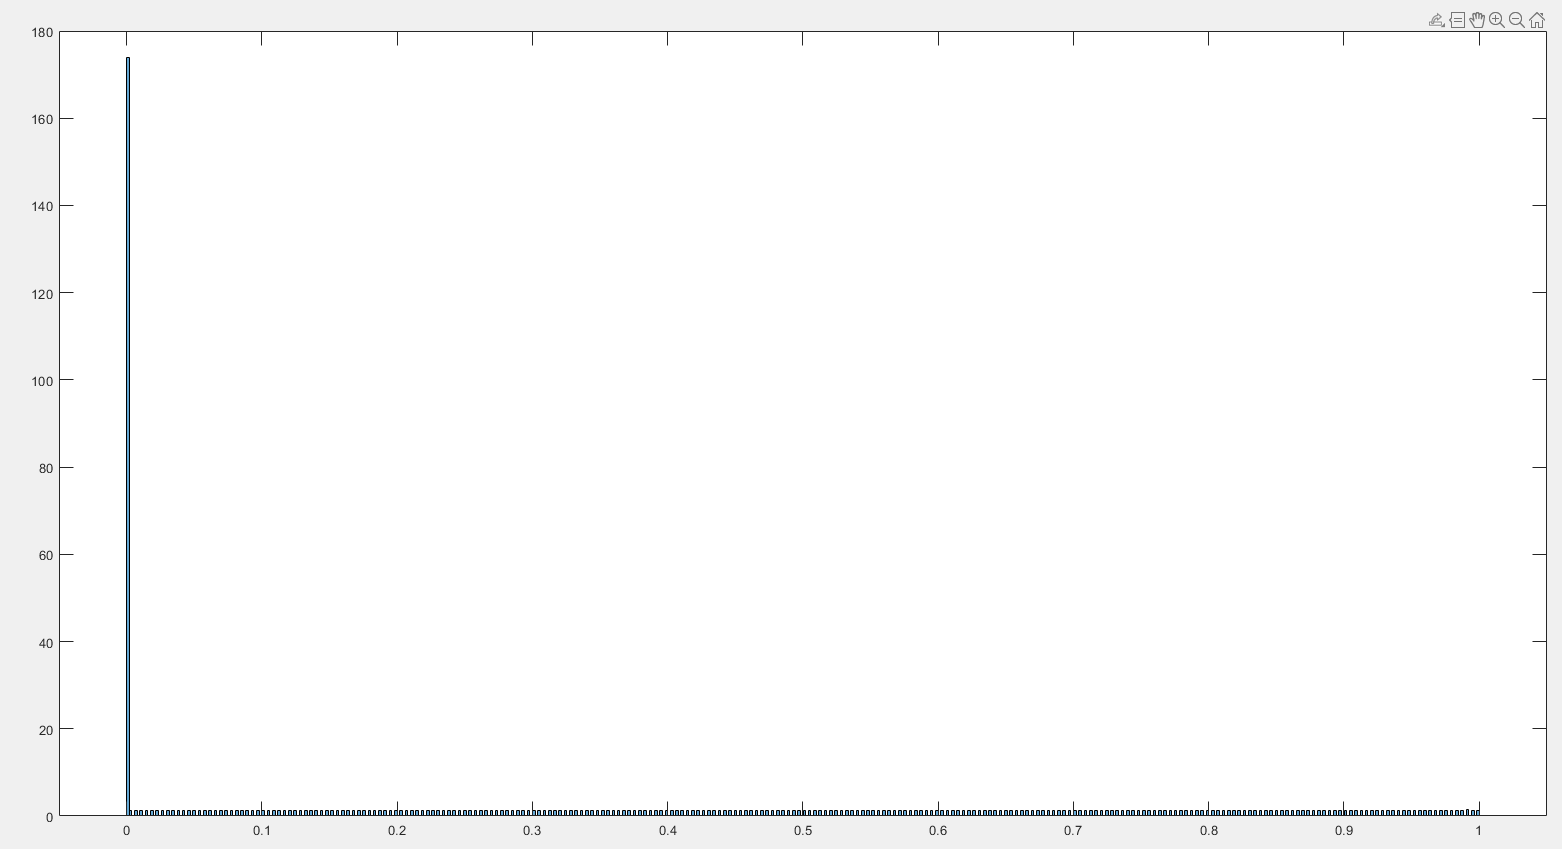

By using these synthetic clean-noisy image pairs, An denoising autoencoder is trained. Since the noise is very strong, even the autoencoder can not perfectly recover the clean image. So in the final classification model, only the encoder part is used and the decoder part is given up. I froze the convolution layers and make the MLP part remains trainable in order to let the encoder learn more information about the original noisy images.

A ResNet is connected after the Encoder to finish the classification problem, as a purpose of avoiding the overfitting, some synthetic noisy images are also added to the training set while the validation set uses only origional noisy images.

In [ ]:
## This code block is used to train the Autoencoder
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pickle
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
import random

##-----import data-----
# Import the clean MNIST data set from the package
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
train_labels = np.reshape(train_labels, [-1])
test_labels = np.reshape(test_labels, [-1])

# Shuffle the clean data set
shuffle_index = np.random.permutation(train_images.shape[0])
train_images = train_images[shuffle_index]
train_labels = train_labels[shuffle_index]
shuffle_index = np.random.permutation(test_images.shape[0])
test_images = test_images[shuffle_index]
test_labels = test_labels[shuffle_index]

# Add noise according to my assumption from the statistical information given by MATLAB
x_train_noisy = np.mod(train_images + np.random.binomial(n=1, p=0.9, size=train_images.shape) * np.random.randint(low=1, high=256, size=train_images.shape), 255)
x_train_noisy = np.clip(x_train_noisy, 0, 255) / 255
x_test_noisy = np.mod(test_images + np.random.binomial(n=1, p=0.9, size=test_images.shape) * np.random.randint(low=1, high=256, size=test_images.shape), 255)
x_test_noisy = np.clip(x_test_noisy, 0, 255) / 255

##-----Autoencoder Model-----
inputs = keras.Input(shape=(28, 28, 1))
x = inputs
# Encoder, Contains 3 CONV block, for each block, there are two conv-averagepooling layers.
for depth in [16, 16, 32]:
    x = layers.Conv2D(filters=depth, kernel_size=3, strides=1, activation="relu", padding="same")(x)
    x = layers.AveragePooling2D(pool_size=2, strides=1, padding="same")(x)
    x = layers.Conv2D(filters=depth, kernel_size=3, strides=1, activation="relu", padding="same")(x)
    x = layers.AveragePooling2D(pool_size=2, strides=1, padding="same")(x)

# After the 2D convolution, a Dense layer is added to compress the encoded information
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(512, activation="relu")(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(28*28*32, activation="relu")(x)
x = layers.Reshape([28, 28, 32])(x)

# Decoder, contaions 3 CONV block, for each block, 3 convolution transpose layers are used. The Decoder is used to filter out the noise
for depth in [32, 16, 16]:
    x = layers.Conv2DTranspose(filters=depth, kernel_size=3, strides=1, activation="relu", padding="same")(x)
    x = layers.Conv2DTranspose(filters=depth, kernel_size=3, strides=1, activation="relu", padding="same")(x)
# The lasy CONV layer is used to recover the data back into the correct shape
x = layers.Conv2D(filters=1, kernel_size=3, strides=1, activation="sigmoid", padding="same")(x)


model = keras.Model(inputs, x)
model.compile(optimizer="rmsprop", loss="binary_crossentropy")

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="./filter_test_new_deep_v1.keras",
        save_best_only=True,
        monitor="val_loss")
]

history = model.fit(x_train_noisy, train_images / 255, epochs=150, shuffle=True, batch_size=512, callbacks=callbacks,
                validation_data=(x_test_noisy, test_images / 255), shuffle=True)


In [ ]:
# This block is used to train the classification problem
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow import keras
import pickle
import matplotlib.pyplot as plt
import random
from tensorflow.keras.datasets import mnist
import pandas as pd

##-----import data-----
# Firstly, import the original noisy data from the project
train_data_path = './636_project1_train_images'
train_label_path = './636_project1_train_labels'
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

train_data = pickle.load(open(train_data_path, 'rb'))
train_label = pickle.load(open(train_label_path, 'rb'))
train_data = train_data.numpy() / 255
train_label = train_label.numpy()
# shuffle the original data set and split it into training and validation data set
shuffle_index = np.random.permutation(train_data.shape[0])
train_data = train_data[shuffle_index]
train_label = train_label[shuffle_index]
val_data = train_data[0:20000]
val_label = train_label[0:20000]
train_data = train_data[20000:]
train_label = train_label[20000:]

# import clean MNIST data set and shuffle it
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
train_labels = np.reshape(train_labels, [-1])
test_labels = np.reshape(test_labels, [-1])
shuffle_index = np.random.permutation(train_images.shape[0])
train_images = train_images[shuffle_index]
train_labels = train_labels[shuffle_index]
shuffle_index = np.random.permutation(test_images.shape[0])
test_images = test_images[shuffle_index]
test_labels = test_labels[shuffle_index]

# Add noise to the clean MNIST data according to my assumption for the noise 
x_train_noisy = np.mod(train_images + np.random.binomial(n=1, p=0.9, size=train_images.shape) * np.random.randint(low=1, high=256, size=train_images.shape), 255)
x_train_noisy = np.clip(x_train_noisy, 0, 255) / 255
x_test_noisy = np.mod(test_images + np.random.binomial(n=1, p=0.9, size=test_images.shape) * np.random.randint(low=1, high=256, size=test_images.shape), 255)
x_test_noisy = np.clip(x_test_noisy, 0, 255) / 255

# combine the original noisy image set from the project and my synthetic noisy images to avoid early overfitting issue.
train_data = np.concatenate((train_data, x_train_noisy), axis=0)
train_label = np.concatenate((train_label, train_labels), axis=0)

##-----Model for Classification------
# First, import the autoencoder trained before. But just the encoder part and the Dense layers are used. The decoder part is aborted
autoencoder = keras.models.load_model("./filter_test_new_deep_v1.keras")
autoencoder.trainable = False
new_model = keras.Sequential()
for ix in range(0, 17 + 1):
    curr_layer = autoencoder.get_layer(index=ix)
    new_model.add(curr_layer)
# Set the Dense layers to be trainable, in order to learn more information from the original noisy dataset.
new_model.trainable = True
for layer in new_model.layers[:-4]:
    layer.trainable = False
new_model.summary()

# The Squeeze-Extraction Net is not usefull in this project, so this part is abandoned
def SENet(input, depth):
    x = layers.GlobalAveragePooling2D()(input)
    x = layers.Reshape([1, 1, depth])(x)
    x = layers.Dense(int(depth / 2), activation="relu")(x)
    x = layers.Dense(depth, activation="sigmoid")(x)
    return x

# The classification model with encoder embeded. The whole structure is: Input -> encoder (pretrained) -> ResNet
inputs = keras.Input(shape=(28, 28, 1))
x = new_model(inputs) # Encoder part (pretrained, but the Dense layers are trainable)
x = layers.Reshape([28, 28, 32])(x)
for depth in [32, 32, 32, 64, 64]:  # Simple ResNet
    res = x

    unique_id = random.randint(1, 99999999)
    x = layers.Conv2D(filters=depth, kernel_size=3, strides=1, padding='same', activation='relu', name="my_layer_name_{}".format(unique_id))(x)
    # w1 = SENet(input=x, depth=depth)
    # x = layers.multiply([x, w1])
    x = layers.MaxPooling2D(pool_size=2, strides=1, padding='same')(x)

    unique_id = random.randint(1, 99999999)
    x = layers.Conv2D(filters=depth, kernel_size=3, strides=1, padding='same', activation='relu', name="my_layer_name_{}".format(unique_id))(x)
    # w2 = SENet(input=x, depth=depth)
    # x = layers.multiply([x, w2])
    x = layers.MaxPooling2D(pool_size=2, strides=1, padding='same')(x)

    unique_id = random.randint(1, 99999999)
    res = layers.Conv2D(filters=depth, kernel_size=1, strides=1, padding='same', activation='tanh', name="my_layer_name_{}".format(unique_id))(res)
    # w3 = SENet(input=res, depth=depth)
    # res = layers.multiply([res, w3])

    x = layers.add([x, res])
    # x = layers.BatchNormalization()(x)

x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.5)(x)
# x = layers.Dense(64, activation='relu')(x)
unique_id = random.randint(1, 99999999)
x = layers.Dense(10, activation='softmax', name="my_layer_name_{}".format(unique_id))(x)

model = keras.Model(inputs, x)
model.summary()

shuffle_index = np.random.permutation(train_data.shape[0])
train_data = train_data[shuffle_index]
train_label = train_label[shuffle_index]

model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="./project_2.keras",
        save_best_only=True,
        monitor="val_loss")
]

history = model.fit(train_data, train_label, epochs=300, callbacks=callbacks, batch_size=512,
                    validation_data=(val_data, val_label), shuffle=True)
